In [4]:
!pip install shap

# Deploy the model and evaluate the metrics

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. **Read and preprocess the data**
data = pd.read_csv('adm_data_clean.csv')  # Replace with your actual file path
data = data.drop(columns=['Serial No.'])  # Remove unnecessary column

# 2. **Split data into features (X) and target (y)**
X = data.drop(columns=['Chance of Admit'])
y = data['Chance of Admit']

# 3. **Identify data types**
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# 4. **Define pipelines for different data types**
# Pipeline for numerical columns
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())                 # Standardize features
])

# Pipeline for categorical columns
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # One-hot encode categorical features
])

# **Combine pipelines for both numerical and categorical data**
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

# 5. **Create the overall pipeline**
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 6. **Define the parameter grid**
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', 0.5],  # Replace 'auto'
    'regressor__bootstrap': [True, False]
}

# 7. **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. **Use GridSearchCV to find the best hyperparameters**
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid,
                           cv=5, scoring='r2', verbose=2, n_jobs=-1)

# Train the model
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("\n*** Best Parameters ***")
print(best_params)

# 9. **Evaluate on the test set**
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n*** Model Evaluation on Test Set ***")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2 Score: {r2}")

# 10. **Cross-validation for overall model evaluation**
cv_scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='r2')
print("\n*** Cross-validated R^2 Scores ***")
print(f"Scores: {cv_scores}")
print(f"Mean R^2 from CV: {cv_scores.mean()}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits

*** Best Parameters ***
{'regressor__bootstrap': False, 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}

*** Model Evaluation on Test Set ***
MAE: 0.04768722839558317
MSE: 0.0046663049763361235
R^2 Score: 0.8192990730379701

*** Cross-validated R^2 Scores ***
Scores: [0.63568618 0.74076756 0.76715982 0.82029997 0.79463883]
Mean R^2 from CV: 0.7517104711862908


# Graphs

C:\Users\thanh\AppData\Local\Temp\ipykernel_22800\800537343.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette='viridis')


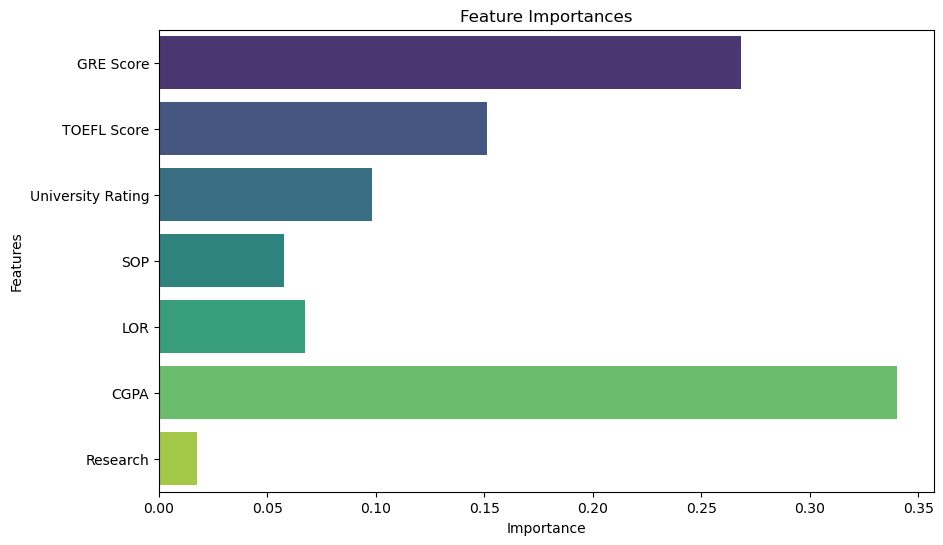

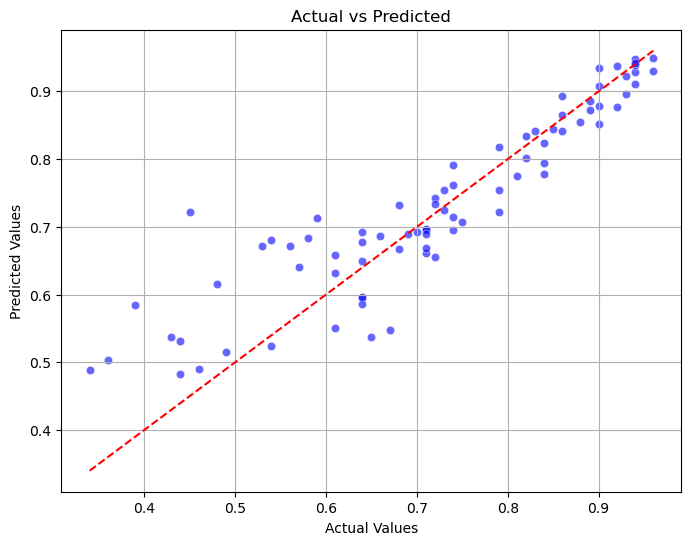

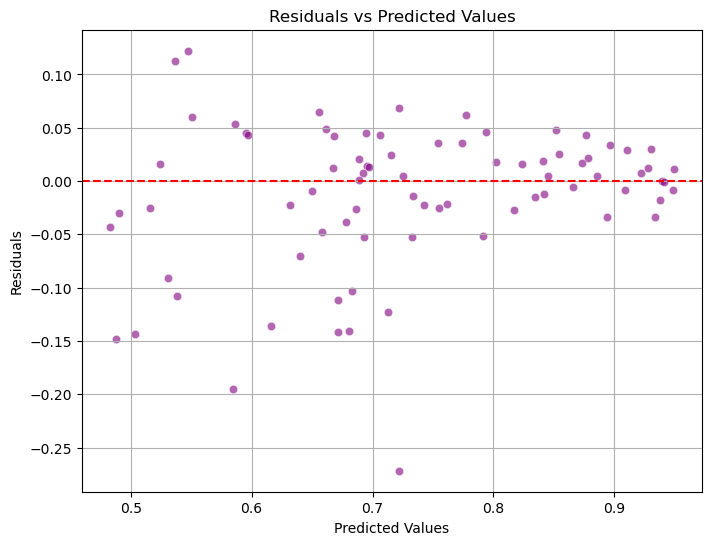

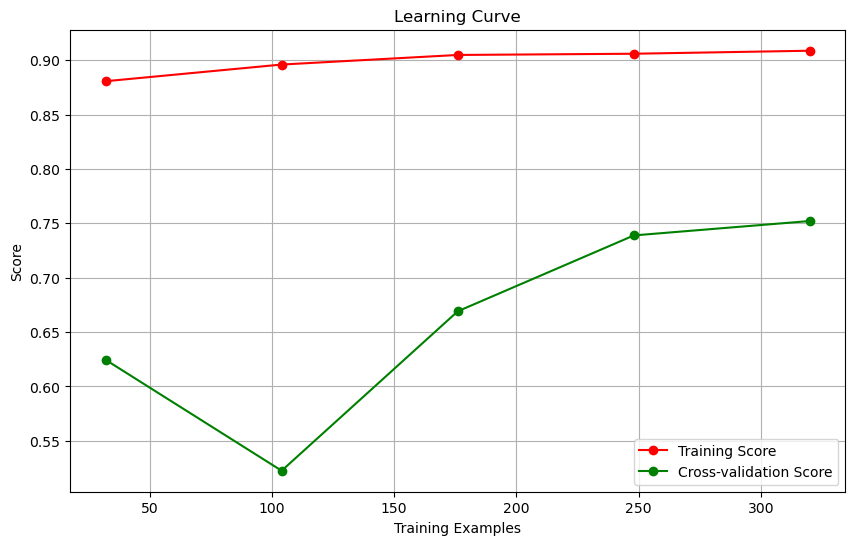

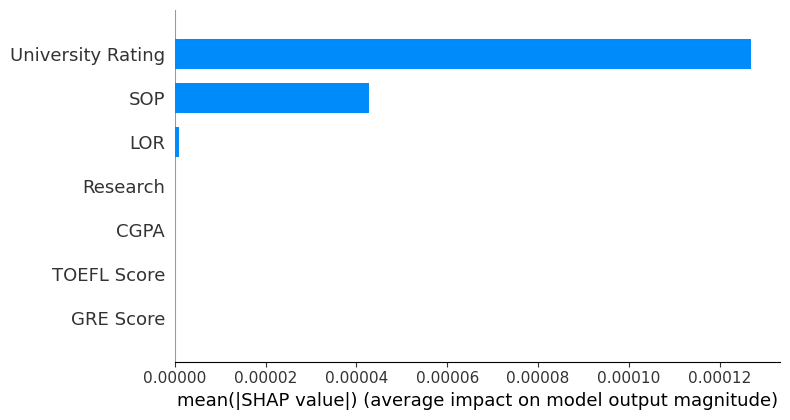

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
import numpy as np
import shap
import warnings
warnings.filterwarnings('ignore')

# 1. Feature Importance
def plot_feature_importance(model, features):
    feature_importances = model.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=features, palette='viridis')
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()

# 2. Actual vs Predicted
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Đường 45 độ
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    plt.grid(True)
    plt.show()

# 3. Residuals vs Predicted
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='purple')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')
    plt.grid(True)
    plt.show()

# 4. Learning Curve
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Score")
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# 5. SHAP Summary Plot
def plot_shap_summary(model, X):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.summary_plot(shap_values, X, plot_type="bar")

plot_feature_importance(best_pipeline.named_steps['regressor'], X.columns)
plot_actual_vs_predicted(y_test, y_pred)
plot_residuals(y_test, y_pred)
plot_learning_curve(best_pipeline.named_steps['regressor'], X, y)
plot_shap_summary(best_pipeline.named_steps['regressor'], X)
